<h1>Crawl Data</h1>

In [ ]:
!pip install scrapy

     |████████████████████████████████| 254 kB 4.2 MB/s 
     |████████████████████████████████| 251 kB 42.0 MB/s 
     |████████████████████████████████| 65 kB 3.2 MB/s 
     |████████████████████████████████| 3.2 MB 43.6 MB/s 
     |████████████████████████████████| 3.1 MB 32.8 MB/s 
     |████████████████████████████████| 47 kB 4.9 MB/s 
     |████████████████████████████████| 3.2 MB 39.3 MB/s 
     |████████████████████████████████| 54 kB 2.0 MB/s 
     |████████████████████████████████| 74 kB 3.2 MB/s 
  Created wheel for protego: filename=Protego-0.1.16-py3-none-any.whl size=7782 sha256=9afa07a652243f4453e97b560189e8452db8f2408ffd9b61877b8eb27e8301ca
  Stored in directory: /root/.cache/pip/wheels/ca/44/01/3592ccfbcfaee4ab297c4097e6e9dbe1c7697e3531a39877ab
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-py3-none-any.whl size=11515 sha256=568cd8f6376f31d397bce668bf95c8df919b171d1e84f2c0478572ff74889f8a
  Stored in directory: /root/.cache/pip/wheels/2d/18/21/3c6a732eaa

In [ ]:
!scrapy startproject fifa_crawler

New Scrapy project 'fifa_crawler', using template directory '/usr/local/lib/python3.7/dist-packages/scrapy/templates/project', created in:
    /content/fifa_crawler

You can start your first spider with:
    cd fifa_crawler
    scrapy genspider example example.com


In [ ]:
cd fifa_crawler

/content/fifa_crawler


In [ ]:
!pip install spider3

In [ ]:
#crawl_players_urls.py
#crawl id of players
import scrapy

#https://docs.scrapy.org/en/latest/intro/tutorial.html
#https://docs.scrapy.org/en/0.22/topics/selectors.html
class PlayerUrlSpider(scrapy.Spider):
  name='players_urls' #name to crawl with scrapy
  
  def start_requests(self):
    urls = ['https://sofifa.com/players?col=oa&sort=desc&offset=0']
    for url in urls:
      yield scrapy.Request(url=url, callback=self.parse)
  
  def parse(self, response):
    for player in response.css('.col-name'): #selector css query
      player_links = player.xpath('a/@href').re(r'/player/\w+') #get id of each player
      if len(player_links) > 0:
        yield {'player_url': player_links[0]}
    offset = response.url[51:]
    print("current offset " + str(offset))
    end_offset = 18959 
    #change to next page
    if int(offset) <= end_offset:
      next_page_url = 'https://sofifa.com/players?col=oa&sort=desc&offset=' + str(int(offset) + 60) #60 is total number of players in an offset -> each offset url increase +60
      yield scrapy.Request(url=next_page_url)

In [ ]:
!scrapy crawl players_urls -o /content/fifa_crawler/dataset/players_urls.json

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
{'player_url': '/player/258884'}
2021-08-24 07:01:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://sofifa.com/players?col=oa&sort=desc&offset=16500>
{'player_url': '/player/233030'}
2021-08-24 07:01:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://sofifa.com/players?col=oa&sort=desc&offset=16500>
{'player_url': '/player/259398'}
2021-08-24 07:01:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://sofifa.com/players?col=oa&sort=desc&offset=16500>
{'player_url': '/player/200263'}
2021-08-24 07:01:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://sofifa.com/players?col=oa&sort=desc&offset=16500>
{'player_url': '/player/260935'}
2021-08-24 07:01:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://sofifa.com/players?col=oa&sort=desc&offset=16500>
{'player_url': '/player/239689'}
2021-08-24 07:01:54 [scrapy.core.scraper] DEBUG: Scraped from <200 https://sofifa.com/players?col=oa&sort=desc&offset=16

In [ ]:
import json

#remove duplicated rows in json after crawling id of players
with open('/content/fifa_crawler/dataset/players_urls.json') as json_data:
  player_info_data = json.load(json_data)
  remove_duplicated_id = {each['player_url'] : each for each in player_info_data}.values()
  jsonString = json.dumps(list(remove_duplicated_id))
  jsonFile = open("/content/fifa_crawler/dataset/players_urls_removed_duplicated_id", "w")
  jsonFile.write(jsonString)
  jsonFile.close()

In [ ]:
#crawl_players_info.py
#crawl info of player
import scrapy
import json

class PlayerInfoSpider(scrapy.Spider):
  name='players_info' #name to crawl with scrapy
  
  def __init__(self):
    try:
      with open('/content/fifa_crawler/dataset/players_urls_removed_duplicated_id') as f:
        self.players = json.load(f)
      self.player_count = 1
    except IOError:
      print("File not found")

  def start_requests(self):
    urls = ['https://sofifa.com/player/158023?units=mks']
    for url in urls:
      yield scrapy.Request(url=url, callback=self.parse)
  
  def parse(self, response):
    for player in response.css('.info'):
      player_id = player.xpath('//div[@class="card" and h5="Profile"]//li[label = "ID"]/text()').get() #get id of player
      player_short_name = player.xpath('//div[@class="flex-centered header"]//h1/text()').get() #get short name of player
      player_name = player.xpath('//div[@class="info"]/h1/text()').get().split('(')[0].strip() #get full name of player
      player_info = player.xpath('//div[@class="meta bp3-text-overflow-ellipsis"]//span/text()').getall() #get all positions of player
      player_info = [info for info in player_info if info != ' ' and info.isupper()]
      player_url_photo = player.xpath('//div[@class="bp3-card player" ]//img/@data-src').getall()[0] #get url face of player
      player_primary_position = player.xpath('//li[@class="bp3-text-overflow-ellipsis"]/span[contains(@class, "pos")]/text()').get() #get primary positions of player
      #get all info of player, add to list and split 
      player_info1 = player.xpath('//div[@class="meta bp3-text-overflow-ellipsis"]/text()').getall()
      player_info1 = [inf for inf in player_info1 if inf != ' ']
      age, month, day, year, height, weight = player_info1[0].split()
      age = age[:-4] #get age of player
      month = month.replace('(', '') #get month
      day = int(day.replace(',', '')) #get day
      year = int(year.replace(')', '')) #get year
      height = int(height[:-2]) #get height of player
      weight = int(weight[:-2]) #get weight of player
      #s_val = player.xpath('//div[@class="sub"]//text()').getall() #['Overall Rating', 'Potential', 'Value', 'Wage']
      overrating_potential = player.xpath('//section[@class="card spacing"]/div/div[@class = "column col-3"]/div/span/text()').getall() #get overall rating + potential of player
      value_wage = player.xpath('//section[@class="card spacing"]/div/div/div[not (@class)]/text()').getall() #get value + wage of player
      #weakfoot_skill_reputation = player.xpath('//div[@class="card" and h5="Profile"]//li[label != "ID"]/text()').getall() #get weak foot + skill + reputation of player
      #other_attribute_profile = player.xpath('//div[@class="card" and h5="Profile"]//li/span[not (@class)]/text()').getall() #get work rate + body type + real face + release clause of player
      attribute_profile_label = player.xpath('//div[@class="card" and h5="Profile"]//label/text()').getall()
      attribute_profile_value = player.xpath('//div[@class="card" and h5="Profile"]//li[label != "ID"]/text()').getall() #get weak foot + skill + reputation of player
      attribute_profile_value = [val for val in attribute_profile_value if val != ' ']
      attribute_profile_value += player.xpath('//div[@class="card" and h5="Profile"]//li/span[not (@class)]/text()').getall() #get work rate + body type + real face + release clause of player
      zip_all_attribute_profule = {k:v for k, v in zip(attribute_profile_label, attribute_profile_value)}
      zip_all_attribute_profule["International Reputation"] = int(zip_all_attribute_profule["International Reputation"])
      zip_all_attribute_profule["Weak Foot"] = int(zip_all_attribute_profule["Weak Foot"])
      zip_all_attribute_profule["Skill Moves"] = int(zip_all_attribute_profule["Skill Moves"])

      player_teams = player.xpath('//div[@class="card"]//h5//a/text()').getall() #get team of player
      player_teams_values = player.xpath('///div[@class="card"]//ul[contains(@class,"pl text-right")]//li[1]//span[1]/text()').re(r'\w+') #get value of team 
      teams = {'teams':{k:int(v) for k, v in zip(player_teams, player_teams_values)}}
      #get list all info detail of player
      player_info_detail = player.xpath('//div[@class="card"]//ul//li/span[2]//text()').re(r'[a-zA-Z ]+')
      player_info_detail += player.xpath('//div[@class="card" and h5="Goalkeeping"]//ul//li/text()').getall() #add missing goalkeeping to list
      player_info_detail.insert(-8, "Composure") #insert missing info detail 
      #get list all info detail value of player
      player_info_detail_value = player.xpath('//div[@class="card" and h5 !="Profile" and h5 != "Traits" and not(img)]/ul//li/span[1]//text()').getall()
      missing_composure_value = player.xpath('//div[@class="card"]//ul//li[text()=" Composure"]/text()').get()
      if missing_composure_value == None:
        player_info_detail_value.insert(25, 50) #insert composure value to some player has missing composure 
      attacking = {'attacking':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[:5], player_info_detail_value[:5])}} #get attacking values of player
      skill = {'skill':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[5:10], player_info_detail_value[5:10])}} #get skill values of player
      movement = {'movement':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[10:15], player_info_detail_value[10:15])}} #get movement values of player
      power = {'power':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[15:20], player_info_detail_value[15:20])}} #get power values of player
      mentality = {'mentality':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[20:26], player_info_detail_value[20:26])}} #get mentality values of player
      defending = {'defending':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[26:29], player_info_detail_value[26:29])}} #get defending values of player
      goalkeeping = {'goalkeeping':{k.replace(' ', ''):int(v) for k, v in zip(player_info_detail[29:], player_info_detail_value[29:])}} #get goalkeeping values of player
      player_traits = player.xpath('//div[@class="card" and h5="Traits"]//ul//li//text()').getall() #get traits of player
      player_specialities = player.xpath('//div[@class="card" and h5="Player Specialities"]//ul//li//a/text()').getall() #get specialities of player
      #get nationality and its logo img url of player
      player_nationality = player.xpath('//div[@class="meta bp3-text-overflow-ellipsis"]/a/@title').get()
      player_nationality_logo_url = player.xpath('//div[@class="meta bp3-text-overflow-ellipsis"]//img/@data-src').get()
      nationality = {'name': player_nationality, 'url': player_nationality_logo_url}
      #get club and its logo img url of player
      player_club = player.xpath('//div[@class="card"]//h5/a/text()').getall()
      player_club_logo_url = player.xpath('//div[@class="card"]//img/@data-src').getall()
      national_club, club = {}, {}
      for k, v in zip(player_club, player_club_logo_url):
        if k == player_nationality:
          national_club.update({'name': k, 'url': v})
        else:
          club.update({'name': k, 'url': v})
      #replace release clause if none
      player_info_dict = {'id': player_id, 'name': player_name, 'short_name': player_short_name, 'photo_url': player_url_photo, 'primary_position': player_primary_position, 
                          'positions': player_info, 'age': age, 'birth_date': '{}/{}/{}'.format(year, month, day), 'height': height, 'weight': weight,
                          'Overall Rating': int(overrating_potential[0]), 'Potential': int(overrating_potential[1]), 'Value': value_wage[2], 'Wage': value_wage[3]}
      '''
      'Preferred Foot': weakfoot_skill_reputation[0], 'Weak Foot': int(weakfoot_skill_reputation[1]), 'Skill Moves': int(weakfoot_skill_reputation[3]),
      'International Reputation': int(weakfoot_skill_reputation[5]), 'Work Rate': other_attribute_profile[0], 'Body Type': other_attribute_profile[1],
      'Real Face': other_attribute_profile[2], 'Release Clause': other_attribute_profile[3]
      '''
      player_info_dict.update(zip_all_attribute_profule)
      player_info_dict.update(teams)
      player_info_dict.update(attacking)
      player_info_dict.update(skill)
      player_info_dict.update(movement)
      player_info_dict.update(power)
      player_info_dict.update(mentality)
      player_info_dict.update(defending)
      player_info_dict.update(goalkeeping)
      player_info_dict.update({'player_traits': player_traits})
      player_info_dict.update({'player_specialities': player_specialities})
      player_info_dict.update({'nationality': nationality})
      player_info_dict.update({'club': club})
      player_info_dict.update({'nation_club': national_club})
      print("player_count" + str(self.player_count) + "\n")
      yield player_info_dict
      if self.player_count < len(self.players):
        next_page_url = 'https://sofifa.com' + self.players[self.player_count]['player_url'] + '?units=mks'
        self.player_count += 1
        yield scrapy.Request(url=next_page_url, callback=self.parse) #dont_filter=True: use this for duplicated urls 

In [ ]:
!scrapy crawl players_info -o /content/fifa_crawler/dataset/players_statistic.json

In [ ]:
!scrapy crawl players_info

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
{'id': '261410', 'name': 'Léider Sebastián Berdugo Ruiz', 'short_name': 'L. Berdugo', 'photo_url': 'https://cdn.sofifa.com/players/261/410/21_120.png', 'primary_position': 'CAM', 'positions': ['CM'], 'age': '18', 'birth_date': '2002/Feb/19', 'height': 176, 'weight': 69, 'Overall Rating': 54, 'Potential': 71, 'Value': '€275K', 'Wage': '€500', 'Preferred Foot': 'Right', 'Weak Foot': 3, 'Skill Moves': 2, 'International Reputation': 1, 'Work Rate': 'Medium/ Medium', 'Body Type': 'Lean (170-185)', 'Real Face': 'No', 'Release Clause': '€557K', 'teams': {'Junior FC': 70}, 'attacking': {'Crossing': 43, 'Finishing': 41, 'HeadingAccuracy': 45, 'ShortPassing': 63, 'Volleys': 36}, 'skill': {'Dribbling': 52, 'Curve': 38, 'FKAccuracy': 39, 'LongPassing': 58, 'BallControl': 46}, 'movement': {'Acceleration': 61, 'SprintSpeed': 65, 'Agility': 59, 'Reactions': 55, 'Balance': 75}, 'power': {'ShotPower': 51, 'Jumping': 65, 'Stamina': 53, 'Strength':

<h1>Preprocessing Data</h1>

In [ ]:
import json

#split dict of all attributes of players to specific columns
Crossing, Finishing, HeadingAccuracy, ShortPassing, Volleys = [], [], [], [], []
Dribbling, Curve, FK_Accuracy, Long_Passing, Ball_Control = [], [], [], [], []
Acceleration, Sprint_Speed, Agility, Reactions, Balance = [], [], [], [], []
Shot_Power, Jumping, Stamina, Strength, Long_Shots = [], [], [], [], []
Aggression, Interceptions, Positioning, Vision, Penalties, Composure = [], [], [], [], [], []
Defensive_Awareness, Standing_Tackle, Sliding_Tackle = [], [], []
GK_Diving, GK_Handling, GK_Kicking, GK_Positioning, GK_Reflexes = [], [], [], [], []

with open('/content/players_info.json') as f:
  data = json.load(f)
  for i in range(len(data)):
    for key, value in data[i].items():
      if key == 'attacking':
        Crossing.append(value['Crossing'])
        Finishing.append(value['Finishing'])
        HeadingAccuracy.append(value['HeadingAccuracy'])
        ShortPassing.append(value['ShortPassing'])
        Volleys.append(value['Volleys'])
      elif key == 'skill':
        Dribbling.append(value['Dribbling'])
        Curve.append(value['Curve'])
        FK_Accuracy.append(value['FKAccuracy'])
        Long_Passing.append(value['LongPassing'])
        Ball_Control.append(value['BallControl'])
      elif key == 'movement':
        Acceleration.append(value['Acceleration'])
        Sprint_Speed.append(value['SprintSpeed'])
        Agility.append(value['Agility'])
        Reactions.append(value['Reactions'])
        Balance.append(value['Balance'])
      elif key == 'power':
        Shot_Power.append(value['ShotPower'])
        Jumping.append(value['Jumping'])
        Stamina.append(value['Stamina'])
        Strength.append(value['Strength'])
        Long_Shots.append(value['LongShots'])
      elif key == 'mentality':
        Aggression.append(value['Aggression'])
        Interceptions.append(value['Interceptions'])
        Positioning.append(value['Positioning'])
        Vision.append(value['Vision'])
        Penalties.append(value['Penalties'])
        Composure.append(value['Composure'])
      elif key == 'defending':
        Defensive_Awareness.append(value['DefensiveAwareness'])
        Standing_Tackle.append(value['StandingTackle'])
        Sliding_Tackle.append(value['SlidingTackle'])
      elif key == 'goalkeeping':
        GK_Diving.append(value['GKDiving'])
        GK_Handling.append(value['GKHandling'])
        GK_Kicking.append(value['GKKicking'])
        GK_Positioning.append(value['GKPositioning'])
        GK_Reflexes.append(value['GKReflexes'])

In [ ]:
import pandas as pd

player_info_split_df = pd.DataFrame({'Crossing': Crossing, 'Finishing': Finishing, 'HeadingAccuracy': HeadingAccuracy, 
                                     'ShortPassing': ShortPassing, 'Volleys': Volleys, 'Dribbling': Dribbling, 
                                     'Curve': Curve, 'FK_Accuracy': FK_Accuracy, 'Long_Passing': Long_Passing,
                                     'Ball_Control': Ball_Control, 'Acceleration': Acceleration, 'Sprint_Speed': Sprint_Speed,
                                     'Agility': Agility, 'Reactions': Reactions, 'Balance': Balance,
                                     'Shot_Power': Shot_Power, 'Jumping': Jumping, 'Stamina': Stamina,
                                     'Strength': Strength, 'Long_Shots': Long_Shots, 'Aggression': Aggression,
                                     'Interceptions': Interceptions, 'Positioning': Positioning, 'Vision': Vision,
                                     'Penalties': Penalties, 'Composure': Composure, 'Defensive_Awareness': Defensive_Awareness,
                                     'Standing_Tackle': Standing_Tackle, 'Sliding_Tackle': Sliding_Tackle, 'GK_Diving': GK_Diving,
                                     'GK_Handling': GK_Handling, 'GK_Kicking': GK_Kicking, 'GK_Positioning': GK_Positioning, 'GK_Reflexes': GK_Reflexes})
player_info_split_df.head()

,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
df1 = pd.read_json('/content/players_info.json', encoding='utf-8-sig')
df1.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,attacking,skill,movement,power,mentality,defending,goalkeeping,player_traits,player_specialities,nationality,club,nation_club
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"[RW, ST, CF]",33,1987/Jun/24,170,72,93,93,€103.5M,€560K,Left,4,4,5,Medium/ Low,Unique,Yes,€212.2M,"{'FC Barcelona': 84, 'Argentina': 83}","{'Crossing': 85, 'Finishing': 95, 'HeadingAccu...","{'Dribbling': 96, 'Curve': 93, 'FKAccuracy': 9...","{'Acceleration': 91, 'SprintSpeed': 80, 'Agili...","{'ShotPower': 86, 'Jumping': 68, 'Stamina': 72...","{'Aggression': 44, 'Interceptions': 40, 'Posit...","{'DefensiveAwareness': 32, 'StandingTackle': 3...","{'GKDiving': 6, 'GKHandling': 11, 'GKKicking':...","[Finesse Shot, Long Shot Taker (AI), Speed Dri...","[#Dribbler, #Distance Shooter, #FK Specialist,...","{'name': 'Argentina', 'url': 'https://cdn.sofi...","{'name': 'FC Barcelona', 'url': 'https://cdn.s...","{'name': 'Argentina', 'url': 'https://cdn.sofi..."
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,[ST],31,1988/Aug/21,185,81,92,92,€124.5M,€270K,Right,4,4,4,High/ Medium,Unique,Yes,€205.4M,"{'FC Bayern München': 84, 'Poland': 77}","{'Crossing': 71, 'Finishing': 95, 'HeadingAccu...","{'Dribbling': 85, 'Curve': 79, 'FKAccuracy': 8...","{'Acceleration': 77, 'SprintSpeed': 79, 'Agili...","{'ShotPower': 90, 'Jumping': 84, 'Stamina': 76...","{'Aggression': 81, 'Interceptions': 49, 'Posit...","{'DefensiveAwareness': 35, 'StandingTackle': 4...","{'GKDiving': 15, 'GKHandling': 6, 'GKKicking':...","[Solid Player, Finesse Shot, Outside Foot Shot...","[#Aerial Threat, #Distance Shooter, #Clinical ...","{'name': 'Poland', 'url': 'https://cdn.sofifa....","{'name': 'FC Bayern München', 'url': 'https://...","{'name': 'Poland', 'url': 'https://cdn.sofifa...."
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"[ST, LW]",35,1985/Feb/5,187,83,92,92,€63M,€220K,Right,4,5,5,High/ Low,Unique,Yes,€104M,"{'Juventus': 83, 'Portugal': 83}","{'Crossing': 84, 'Finishing': 95, 'HeadingAccu...","{'Dribbling': 88, 'Curve': 81, 'FKAccuracy': 7...","{'Acceleration': 87, 'SprintSpeed': 91, 'Agili...","{'ShotPower': 94, 'Jumping': 95, 'Stamina': 84...","{'Aggression': 63, 'Interceptions': 29, 'Posit...","{'DefensiveAwareness': 28, 'StandingTackle': 3...","{'GKDiving': 7, 'GKHandling': 11, 'GKKicking':...","[Power Free-Kick, Flair, Long Shot Taker (AI),...","[#Aerial Threat, #Dribbler, #Distance Shooter,...","{'name': 'Portugal', 'url': 'https://cdn.sofif...","{'name': 'Juventus', 'url': 'https://cdn.sofif...","{'name': 'Portugal', 'url': 'https://cdn.sofif..."
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,[GK],27,1993/Jan/7,188,87,91,93,€120M,€125K,Right,3,1,3,Medium/ Medium,Unique,Yes,€255M,"{'Atlético Madrid': 83, 'Slovenia': 73}","{'Crossing': 13, 'Finishing': 11, 'HeadingAccu...","{'Dribbling': 12, 'Curve': 13, 'FKAccuracy': 1...","{'Acceleration': 43, 'SprintSpeed': 60, 'Agili...","{'ShotPower': 59, 'Jumping': 78, 'Stamina': 41...","{'Aggression': 34, 'Interceptions': 19, 'Posit...","{'DefensiveAwareness': 27, 'StandingTackle': 1...","{'GKDiving': 87, 'GKHandling': 92, 'GKKicking'...","[GK Long Throw, Comes For Crosses]",[],"{'name': 'Slovenia', 'url': 'https://cdn.sofif...","{'name': 'Atlético Madrid', 'url': 'https://cd...","{'name': 'Slovenia', 'url': 'https://cdn.sofif..."
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"[CM, CAM, CF]",29,1991/Jun/28,181,70,91,91,€127.5M,€370K,Right,5,4,4,High/ High,Unique,Yes,€235.9M,"{'Manchester City': 85, 'Belgium': 83}","{'Crossing': 94, 'Finishing': 82, 'HeadingAccu...","{'D

In [ ]:
df1 = df1.drop(['attacking', 'skill', 'movement', 'power', 'mentality', 'defending', 'goalkeeping'], axis=1)
df1.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,nationality,club,nation_club
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"[RW, ST, CF]",33,1987/Jun/24,170,72,93,93,€103.5M,€560K,Left,4,4,5,Medium/ Low,Unique,Yes,€212.2M,"{'FC Barcelona': 84, 'Argentina': 83}","[Finesse Shot, Long Shot Taker (AI), Speed Dri...","[#Dribbler, #Distance Shooter, #FK Specialist,...","{'name': 'Argentina', 'url': 'https://cdn.sofi...","{'name': 'FC Barcelona', 'url': 'https://cdn.s...","{'name': 'Argentina', 'url': 'https://cdn.sofi..."
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,[ST],31,1988/Aug/21,185,81,92,92,€124.5M,€270K,Right,4,4,4,High/ Medium,Unique,Yes,€205.4M,"{'FC Bayern München': 84, 'Poland': 77}","[Solid Player, Finesse Shot, Outside Foot Shot...","[#Aerial Threat, #Distance Shooter, #Clinical ...","{'name': 'Poland', 'url': 'https://cdn.sofifa....","{'name': 'FC Bayern München', 'url': 'https://...","{'name': 'Poland', 'url': 'https://cdn.sofifa...."
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"[ST, LW]",35,1985/Feb/5,187,83,92,92,€63M,€220K,Right,4,5,5,High/ Low,Unique,Yes,€104M,"{'Juventus': 83, 'Portugal': 83}","[Power Free-Kick, Flair, Long Shot Taker (AI),...","[#Aerial Threat, #Dribbler, #Distance Shooter,...","{'name': 'Portugal', 'url': 'https://cdn.sofif...","{'name': 'Juventus', 'url': 'https://cdn.sofif...","{'name': 'Portugal', 'url': 'https://cdn.sofif..."
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,[GK],27,1993/Jan/7,188,87,91,93,€120M,€125K,Right,3,1,3,Medium/ Medium,Unique,Yes,€255M,"{'Atlético Madrid': 83, 'Slovenia': 73}","[GK Long Throw, Comes For Crosses]",[],"{'name': 'Slovenia', 'url': 'https://cdn.sofif...","{'name': 'Atlético Madrid', 'url': 'https://cd...","{'name': 'Slovenia', 'url': 'https://cdn.sofif..."
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"[CM, CAM, CF]",29,1991/Jun/28,181,70,91,91,€127.5M,€370K,Right,5,4,4,High/ High,Unique,Yes,€235.9M,"{'Manchester City': 85, 'Belgium': 83}","[Injury Prone, Leadership, Early Crosser, Long...","[#Dribbler, #Playmaker , #Engine, #Distance Sh...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...","{'name': 'Manchester City', 'url': 'https://cd...","{'name': 'Belgium', 'url': 'https://cdn.sofifa..."


In [ ]:
df = pd.concat([df1, player_info_split_df], axis=1)
df.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,nationality,club,nation_club,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"[RW, ST, CF]",33,1987/Jun/24,170,72,93,93,€103.5M,€560K,Left,4,4,5,Medium/ Low,Unique,Yes,€212.2M,"{'FC Barcelona': 84, 'Argentina': 83}","[Finesse Shot, Long Shot Taker (AI), Speed Dri...","[#Dribbler, #Distance Shooter, #FK Specialist,...","{'name': 'Argentina', 'url': 'https://cdn.sofi...","{'name': 'FC Barcelona', 'url': 'https://cdn.s...","{'name': 'Argentina', 'url': 'https://cdn.sofi...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,[ST],31,1988/Aug/21,185,81,92,92,€124.5M,€270K,Right,4,4,4,High/ Medium,Unique,Yes,€205.4M,"{'FC Bayern München': 84, 'Poland': 77}","[Solid Player, Finesse Shot, Outside Foot Shot...","[#Aerial Threat, #Distance Shooter, #Clinical ...","{'name': 'Poland', 'url': 'https://cdn.sofifa....","{'name': 'FC Bayern München', 'url': 'https://...","{'name': 'Poland', 'url': 'https://cdn.sofifa....",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"[ST, LW]",35,1985/Feb/5,187,83,92,92,€63M,€220K,Right,4,5,5,High/ Low,Unique,Yes,€104M,"{'Juventus': 83, 'Portugal': 83}","[Power Free-Kick, Flair, Long Shot Taker (AI),...","[#Aerial Threat, #Dribbler, #Distance Shooter,...","{'name': 'Portugal', 'url': 'https://cdn.sofif...","{'name': 'Juventus', 'url': 'https://cdn.sofif...","{'name': 'Portugal', 'url': 'https://cdn.sofif...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,[GK],27,1993/Jan/7,188,87,91,93,€120M,€125K,Right,3,1,3,Medium/ Medium,Unique,Yes,€255M,"{'Atlético Madrid': 83, 'Slovenia': 73}","[GK Long Throw, Comes For Crosses]",[],"{'name': 'Slovenia', 'url': 'https://cdn.sofif...","{'name': 'Atlético Madrid', 'url': 'https://cd...","{'name': 'Slovenia', 'url': 'https://cdn.sofif...",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"[CM, CAM, CF]",29,1991/Jun/28,181,70,91,91,€127.5M,€370K,Right,5,4,4,High/ High,Unique,Yes,€235.9M,"{'Manchester City': 85, 'Belgium': 83}","[Injury Prone, Leadership, Early Crosser, Long...","[#Dribbler, #Playmaker , #Engine, #Distance Sh...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...","{'name': 'Manchester City', 'url': 'https://cd...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
df.to_csv('player_info_preprocessed.csv', index=False)

<h1>Explore Data</h1>

In [ ]:
import pandas as pd

df2 = pd.read_csv('/content/player_info_preprocessed.csv', encoding='utf-8-sig')
df2.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,nationality,club,nation_club,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,€103.5M,€560K,Left,4,4,5,Medium/ Low,Unique,Yes,€212.2M,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...","{'name': 'Argentina', 'url': 'https://cdn.sofi...","{'name': 'FC Barcelona', 'url': 'https://cdn.s...","{'name': 'Argentina', 'url': 'https://cdn.sofi...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,€124.5M,€270K,Right,4,4,4,High/ Medium,Unique,Yes,€205.4M,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...","{'name': 'Poland', 'url': 'https://cdn.sofifa....","{'name': 'FC Bayern München', 'url': 'https://...","{'name': 'Poland', 'url': 'https://cdn.sofifa....",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,€63M,€220K,Right,4,5,5,High/ Low,Unique,Yes,€104M,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...","{'name': 'Portugal', 'url': 'https://cdn.sofif...","{'name': 'Juventus', 'url': 'https://cdn.sofif...","{'name': 'Portugal', 'url': 'https://cdn.sofif...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,€120M,€125K,Right,3,1,3,Medium/ Medium,Unique,Yes,€255M,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],"{'name': 'Slovenia', 'url': 'https://cdn.sofif...","{'name': 'Atlético Madrid', 'url': 'https://cd...","{'name': 'Slovenia', 'url': 'https://cdn.sofif...",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,€127.5M,€370K,Right,5,4,4,High/ High,Unique,Yes,€235.9M,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...","{'name': 'Manchester City', 'url': 'https://cd...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
df2[df2.isnull().any(axis=1)] #print null columns 

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,nationality,club,nation_club,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
139,222665,Martin Ødegaard,M. Ødegaard,https://cdn.sofifa.com/players/222/665/21_120.png,CAM,"['CAM', 'CM']",21,1998/Dec/17,178,68,83,89,€58.5M,€135K,Left,2,5,3,High/ Medium,Lean (170-185),No,NaN,"{'Arsenal': 80, 'Norway': 76}","['Solid Player', 'Flair', 'Playmaker (AI)', 'O...",['#Dribbler'],"{'name': 'Norway', 'url': 'https://cdn.sofifa....","{'name': 'Arsenal', 'url': 'https://cdn.sofifa...","{'name': 'Norway', 'url': 'https://cdn.sofifa....",84,73,52,83,73,86,81,83,81,85,80,77,85,74,83,76,46,78,56,77,63,65,77,87,63,76,65,49,51,14,15,15,8,10
167,201153,Álvaro Borja Morata Martín,Morata,https://cdn.sofifa.com/players/201/153/21_120.png,ST,['ST'],27,1992/Oct/23,190,84,83,83,€39.5M,€80K,Right,4,3,3,High/ High,Normal (185+),Yes,NaN,"{'Juventus': 83, 'Spain': 84}",['Speed Dribbler (AI)'],[],"{'name': 'Spain', 'url': 'https://cdn.sofifa.c...","{'name': 'Juventus', 'url': 'https://cdn.sofif...","{'name': 'Spain', 'url': 'https://cdn.sofifa.c...",73,84,86,80,80,84,78,44,51,84,78,84,72,83,63,80,84,77,80,72,69,24,87,77,75,79,37,14,20,4,5,4,4,5
238,198009,Mattia Perin,M. Perin,https://cdn.sofifa.com/players/198/009/21_120.png,GK,['GK'],27,1992/Nov/10,188,77,82,84,€28M,€70K,Right,3,1,2,Medium/ Medium,Lean (185+),Yes,NaN,{'Genoa': 74},"['Injury Prone', 'Cautious With Crosses']",[],"{'name': 'Italy', 'url': 'https://cdn.sofifa.c...","{'name': 'Genoa', 'url': 'https://cdn.sofifa.c...",{},11,11,12,33,19,19,15,13,31,23,57,56,70,77,30,53,75,30,52,17,25,19,12,44,21,65,20,12,19,82,82,71,79,87
248,193105,Alphonse Areola,A. Areola,https://cdn.sofifa.com/players/193/105/21_120.png,GK,['GK'],27,1993/Feb/27,195,94,82,85,€30M,€71K,Right,3,1,2,Medium/ Medium,Unique,Yes,NaN,{'Fulham': 75},['Comes For Crosses'],[],"{'name': 'France', 'url': 'https://cdn.sofifa....","{'name': 'Fulham', 'url': 'https://cdn.sofifa....",{},20,19,14,48,16,12,16,16,37,22,56,54,58,78,58,57,72,38,80,14,26,23,17,51,25,64,13,18,12,85,79,76,80,85
260,178518,Radja Nainggolan,R. Nainggolan,https://cdn.sofifa.com/players/178/518/21_120.png,CM,"['CAM', 'CM', 'CF']",32,1988/May/4,176,65,82,82,€24M,€115K,Right,3,3,3,High/ High,Unique,Yes,NaN,{'Cagliari': 75},"['Long Shot Taker (AI)', 'Outside Foot Shot']","['#Engine', '#Distance Shooter']","{'name': 'Belgium', 'url': 'https://cdn.sofifa...","{'name': 'Cagliari', 'url': 'https://cdn.sofif...",{},73,75,59,85,75,81,73,68,82,83,71,71,75,83,83,86,74,87,75,89,85,84,84,80,63,84,81,85,86,11,11,14,8,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18377,247085,William Hondermarck,W. Hondermarck,https://cdn.sofifa.com/players/247/085/21_120.png,CDM,"['CM', 'LM']",19,2000/Nov/21,183,74,52,65,€190K,€1K,Right,2,3,1,Medium/ Medium,Normal (170-185),No,NaN,{'Harrogate Town': 61},[],[],"{'name': 'France', 'url': 'https://cdn.sofifa....","{'name': 'Harrogate Town', 'url': 'https://cdn...",{},42,33,47,62,31,50,40,35,56,51,65,66,68,52,63,56,61,63,58,37,56,48,28,55,40,44,50,44,46,13,8,8,7,13
18405,245335,James Pardington,J. Pardington,https://cdn.sofifa.com/players/245/335/21_120.png,GK,['GK'],19,2000/Jul/20,195,80,52,67,€170K,€3K,Right,2,1,1,Medium/ Medium,Lean (185+),No,NaN,{'Mansfie

In [ ]:
print("Number of row: " + str(df2.shape[0]))
print("Number of column: " + str(df2.shape[1]))

Number of row: 18922
Number of column: 62


In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18922 entries, 0 to 18921
Data columns (total 62 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   id                        18922 non-null  int64 
 1   name                      18922 non-null  object
 2   short_name                18922 non-null  object
 3   photo_url                 18922 non-null  object
 4   primary_position          18922 non-null  object
 5   positions                 18922 non-null  object
 6   age                       18922 non-null  int64 
 7   birth_date                18922 non-null  object
 8   height                    18922 non-null  int64 
 9   weight                    18922 non-null  int64 
 10  Overall Rating            18922 non-null  int64 
 11  Potential                 18922 non-null  int64 
 12  Value                     18922 non-null  object
 13  Wage                      18922 non-null  object
 14  Preferred Foot        

In [ ]:
pd.set_option('display.max_columns', None)  
pd.set_option('display.max_rows', None)  
df2.isnull().sum()

id                             0
name                           0
short_name                     0
photo_url                      0
primary_position               0
positions                      0
age                            0
birth_date                     0
height                         0
weight                         0
Overall Rating                 0
Potential                      0
Value                          0
Wage                           0
Preferred Foot                 0
Weak Foot                      0
Skill Moves                    0
International Reputation       0
Work Rate                      0
Body Type                      0
Real Face                      0
Release Clause              1600
teams                          0
player_traits                  0
player_specialities            0
nationality                    0
club                           0
nation_club                    0
Crossing                       0
Finishing                      0
HeadingAcc

In [ ]:
#normalize value and wage to full values
def convert_value_wage_to_numeric(val):
  ele = val[1:]
  if ele.endswith('K'):
    return float(ele[:-1]) * 1000
  elif ele.endswith('M'):
    return float(ele[:-1]) * 1000000
  else:
    return float(ele)

df2['Value'] = df2['Value'].apply(convert_value_wage_to_numeric)
df2['Wage'] = df2['Wage'].apply(convert_value_wage_to_numeric)
df2.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,nationality,club,nation_club,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,€212.2M,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...","{'name': 'Argentina', 'url': 'https://cdn.sofi...","{'name': 'FC Barcelona', 'url': 'https://cdn.s...","{'name': 'Argentina', 'url': 'https://cdn.sofi...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,€205.4M,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...","{'name': 'Poland', 'url': 'https://cdn.sofifa....","{'name': 'FC Bayern München', 'url': 'https://...","{'name': 'Poland', 'url': 'https://cdn.sofifa....",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,€104M,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...","{'name': 'Portugal', 'url': 'https://cdn.sofif...","{'name': 'Juventus', 'url': 'https://cdn.sofif...","{'name': 'Portugal', 'url': 'https://cdn.sofif...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,€255M,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],"{'name': 'Slovenia', 'url': 'https://cdn.sofif...","{'name': 'Atlético Madrid', 'url': 'https://cd...","{'name': 'Slovenia', 'url': 'https://cdn.sofif...",13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,€235.9M,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...","{'name': 'Manchester City', 'url': 'https://cd...","{'name': 'Belgium', 'url': 'https://cdn.sofifa...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


<h1>Continue preprocess data</h1>

In [ ]:
import json

club_list_tmp= []

for key, value in df2.iteritems():
  if key == 'club':
    for i in range(df2.shape[0]):
      club_list_tmp.append(value[i])
club_list_tmp

In [ ]:
for j in range(len(club_list_tmp)):
  if club_list_tmp[j] == '{}':
    club_list_tmp[j] = "{'name': 'No Club', 'url': 'No Club Url'}"
club_list_tmp

In [ ]:
club_list, club_url_list = [], []

for k in range(len(club_list_tmp)):
  tmp_split = club_list_tmp[k].split(',')
  club_list.append(tmp_split[0][10:-1])
  club_url_list.append(tmp_split[1][9:-2])

In [ ]:
nationality_list_tmp = []

for key, value in df2.iteritems():
  if key == 'nationality':
    for i in range(df2.shape[0]):
      nationality_list_tmp.append(value[i])
nationality_list_tmp

In [ ]:
nationality_list, nationality_url_list = [], []

for k in range(len(nationality_list_tmp)):
  tmp_split = nationality_list_tmp[k].split(',')
  nationality_list.append(tmp_split[0][10:-1])
  nationality_url_list.append(tmp_split[1][9:-2])

In [ ]:
nation_club_list_tmp = []

for key, value in df2.iteritems():
  if key == 'nation_club':
    for i in range(df2.shape[0]):
      nation_club_list_tmp.append(value[i])
nation_club_list_tmp

In [ ]:
for j in range(len(nation_club_list_tmp)):
  if nation_club_list_tmp[j] == '{}':
    nation_club_list_tmp[j] = "{'name': 'No Nation Club', 'url': 'No Nation Club Url'}"
nation_club_list_tmp

In [ ]:
nation_club_list, nation_club_url_list = [], []

for k in range(len(nation_club_list_tmp)):
  tmp_split = nation_club_list_tmp[k].split(',')
  nation_club_list.append(tmp_split[0][10:-1])
  nation_club_url_list.append(tmp_split[1][9:-2])

In [ ]:
df2['Release Clause'].fillna("€0M", inplace=True)

In [ ]:
df2['Release Clause'] = df2['Release Clause'].apply(convert_value_wage_to_numeric) #fill 1600 null values with 0 and normalize to full values
df2.head()

In [ ]:
import pandas as pd

player_club_split_df = pd.DataFrame({'club': club_list, 'club_url': club_url_list, 
                                     'nationality': nationality_list, 'nationality_url': nationality_url_list,
                                     'nation_club': nation_club_list, 'nation_club_url': nation_club_url_list})
player_club_split_df.head()

,club,club_url,nationality,nationality_url,nation_club,nation_club_url
0,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png
1,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png
2,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png
3,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png
4,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png


In [ ]:
df2 = df2.drop(['nationality', 'club', 'nation_club'], axis=1)
df2.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
df_merge1 = pd.concat([df2, player_club_split_df], axis=1)
df_merge1.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,club,club_url,nationality,nationality_url,nation_club,nation_club_url
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png


In [ ]:
df_merge1.to_csv('player_info_preprocessed1.csv', index=False)

<h1>Continue Explore Data</h1>

In [ ]:
import pandas as pd

df4 = pd.read_csv('/content/player_info_preprocessed1.csv', encoding='utf-8-sig')
df4.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,club,club_url,nationality,nationality_url,nation_club,nation_club_url
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png


In [ ]:
df4.shape

(18922, 65)

In [ ]:
#total number of players followed by positions
postion_count = df4['primary_position'].value_counts().to_frame().reset_index()
postion_count.columns = ['Positions', 'Total Players']
postion_count

,Positions,Total Players
0,CB,3689
1,ST,2678
2,CAM,2272
3,GK,2098
4,RM,1491
5,CDM,1459
6,CM,1084
7,RB,1030
8,LB,1015
9,LM,897


In [ ]:
#total number of players followed by club
club_count = df4[df4['club'] != 'No Club']['club'].value_counts().to_frame().reset_index()
club_count.columns = ['Club', 'Total Players']
club_count

,Club,Total Players
0,West Ham United,33
1,Parma,33
2,FC Barcelona,33
3,Angers SCO,33
4,Roma,33
...,...,...
678,Shelbourne FC,19
679,Club Athletico Paranaense,19
680,Corinthians,19
681,Jiangsu Suning FC,18


In [ ]:
#total number of players followed by nationality
nationality_count = df4['nationality'].value_counts().to_frame().reset_index()
nationality_count.columns = ['Nationality', 'Total Players']
nationality_count

,Nationality,Total Players
0,England,1722
1,Germany,1189
2,Spain,1075
3,France,1025
4,Argentina,915
...,...,...
158,Saint Lucia,1
159,Vietnam,1
160,Guam,1
161,Aruba,1


In [ ]:
#total number of players followed by nation_club
nation_club_count = df4[df4['nation_club'] != 'No Nation Club']['nation_club'].value_counts().to_frame().reset_index()
nation_club_count.columns = ['Nation Club', 'Total Players']
nation_club_count

,Nation Club,Total Players
0,France,23
1,Wales,23
2,Germany,23
3,Canada,23
4,Finland,23
5,Chile,23
6,Portugal,23
7,Belgium,23
8,Peru,23
9,Sweden,23


In [ ]:
#value and wage of player
value_player_name, value_player = df4.iloc[df4['Value'].argmax()][['short_name', 'Value']].to_list()
print("The player has highest value is {} with {}\u20ac".format(value_player_name, int(value_player)))
wage_player_name, wage_player = df4.iloc[df4['Wage'].argmax()][['short_name', 'Wage']].to_list()
print("The player has highest wage is {} with {}\u20ac".format(wage_player_name, int(wage_player)))

The player has highest value is K. Mbappé with 185500000€
The player has highest wage is L. Messi with 560000€


In [ ]:
#ovr and potential of player
ovr_max_player_name, ovr_max_player = df4.iloc[df4['Overall Rating'].argmax()][['short_name', 'Overall Rating']].to_list()
print("The player has highest ovr is {} with {}".format(ovr_max_player_name, ovr_max_player))
potential_max_player_name, potential_max_player = df4.iloc[df4['Potential'].argmax()][['short_name', 'Potential']].to_list()
print("The player has highest potential is {} with {}".format(potential_max_player_name, potential_max_player))

The player has highest ovr is L. Messi with 93
The player has highest potential is K. Mbappé with 95


In [ ]:
#weight and height of player
weight_max_player_name, weight_max_player = df4.iloc[df4['weight'].argmax()][['short_name', 'weight']].to_list()
print("The player has highest weight is {} with {}kg".format(weight_max_player_name, weight_max_player))
height_max_player_name, height_max_player = df4.iloc[df4['height'].argmax()][['short_name', 'height']].to_list()
print("The player has highest height is {} with {}cm".format(height_max_player_name, height_max_player))

The player has highest weight is A. Akinfenwa with 110kg
The player has highest height is T. Holý with 206cm


In [ ]:
#release clause and age of player
release_clause_max_player_name, release_clause_max_player = df4.iloc[df4['Release Clause'].argmax()][['short_name', 'Release Clause']].to_list()
print("The player has highest release clause is {} with {}\u20ac".format(release_clause_max_player_name, int(release_clause_max_player)))
age_max_player_name, age_max_player = df4.iloc[df4['age'].argmax()][['short_name', 'age']].to_list()
print("The player has highest age is {} with {}".format(age_max_player_name, age_max_player))

The player has highest release clause is K. Mbappé with 357100000€
The player has highest age is K. Miura with 53


<h1>Build Model With Neural Network To Predict Position Of Players</h1>

In [ ]:
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.optimizers import SGD, Adam, Adadelta, RMSprop
import keras.backend as K
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from keras.utils.np_utils import to_categorical

df4 = df4[['primary_position', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
           'Dribbling', 'Curve', 'FK_Accuracy', 'Long_Passing', 'Ball_Control',
           'Acceleration', 'Sprint_Speed', 'Agility', 'Reactions', 'Balance',
           'Shot_Power', 'Jumping', 'Stamina', 'Strength', 'Long_Shots',
           'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
           'Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle',
           'GK_Diving', 'GK_Handling', 'GK_Kicking', 'GK_Positioning', 'GK_Reflexes']]
df4.head()

,primary_position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,RW,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,ST,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,ST,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,GK,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,CM,94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
forward_position = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_position = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_position = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

In [ ]:
df3 = df4.copy()
df3.loc[df3["primary_position"] == "GK", "primary_position"] = 0
df3.loc[df3["primary_position"].isin(defender_position), "primary_position"] = 1
df3.loc[df3["primary_position"].isin(midfielder_position), "primary_position"] = 2
df3.loc[df3["primary_position"].isin(forward_position), "primary_position"] = 3

In [ ]:
df3.head()

,primary_position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,3,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,3,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,3,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,0,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,2,94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
x = df3.drop("primary_position", axis = 1)
x = pd.DataFrame(StandardScaler().fit_transform(x))
y = df3["primary_position"]

In [ ]:
y_cat = to_categorical(y)
y_cat

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       ...,
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 1., 0.]], dtype=float32)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x.values, y_cat, test_size=0.2)

In [ ]:
from keras.layers import Dropout

model = Sequential()
model.add(Dense(60, input_shape = (34,), activation = "relu"))
model.add(Dense(15, activation = "relu"))
model.add(Dropout(0.2))
model.add(Dense(4, activation = "softmax"))
model.compile(Adam(learning_rate = 0.01), "categorical_crossentropy", metrics = ["accuracy"])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 60)                2100      
_________________________________________________________________
dense_1 (Dense)              (None, 15)                915       
_________________________________________________________________
dropout (Dropout)            (None, 15)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 64        
Total params: 3,079
Trainable params: 3,079
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(x_train, y_train, verbose=1, epochs=10)

Epoch 1/10
474/474 [==============================] - 2s 2ms/step - loss: 0.2819 - accuracy: 0.8879
Epoch 2/10
474/474 [==============================] - 1s 2ms/step - loss: 0.2292 - accuracy: 0.9088
Epoch 3/10
474/474 [==============================] - 1s 2ms/step - loss: 0.2094 - accuracy: 0.9166
Epoch 4/10
474/474 [==============================] - 1s 2ms/step - loss: 0.2072 - accuracy: 0.9164
Epoch 5/10
474/474 [==============================] - 1s 2ms/step - loss: 0.2161 - accuracy: 0.9141
Epoch 6/10
474/474 [==============================] - 1s 2ms/step - loss: 0.1983 - accuracy: 0.9213
Epoch 7/10
474/474 [==============================] - 1s 2ms/step - loss: 0.1938 - accuracy: 0.9217
Epoch 8/10
474/474 [==============================] - 1s 2ms/step - loss: 0.1884 - accuracy: 0.9250
Epoch 9/10
474/474 [==============================] - 1s 2ms/step - loss: 0.1929 - accuracy: 0.9204
Epoch 10/10
474/474 [==============================] - 1s 2ms/step - loss: 0.2147 - accuracy: 0.9182

In [ ]:
import numpy as np 

y_pred_class1 = model.predict(x_test)
y_pred_class = np.argmax(y_pred_class1, axis=1)
y_pred = model.predict(x_test)
y_test_class = np.argmax(y_test, axis=1)
print("Accuracy: " + str((np.sum(y_pred_class == y_test_class) * 100.0) / x_test.shape[0]))

Accuracy: 92.76089828269485


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_class, y_pred_class))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       417
           1       0.95      0.95      0.95      1308
           2       0.87      0.94      0.91      1377
           3       0.97      0.80      0.88       683

    accuracy                           0.93      3785
   macro avg       0.95      0.92      0.93      3785
weighted avg       0.93      0.93      0.93      3785



<h1>Build Model With Logistic Regression To Predict Position Of Players</h1>

In [ ]:
df4 = df4[['primary_position', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
           'Dribbling', 'Curve', 'FK_Accuracy', 'Long_Passing', 'Ball_Control',
           'Acceleration', 'Sprint_Speed', 'Agility', 'Reactions', 'Balance',
           'Shot_Power', 'Jumping', 'Stamina', 'Strength', 'Long_Shots',
           'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
           'Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle',
           'GK_Diving', 'GK_Handling', 'GK_Kicking', 'GK_Positioning', 'GK_Reflexes']]

forward_position = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_position = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_position = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]

df5 = df4.copy()
df5.loc[df5["primary_position"] == "GK", "primary_position"] = 'GK'
df5.loc[df5["primary_position"].isin(defender_position), "primary_position"] = 'DF'
df5.loc[df5["primary_position"].isin(midfielder_position), "primary_position"] = 'MF'
df5.loc[df5["primary_position"].isin(forward_position), "primary_position"] = 'FW'
df5.head()

,primary_position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,FW,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,FW,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,FW,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,GK,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,MF,94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

def predict_position(df, model):
    if df['primary_position'] is np.nan:
        pred_position = model.predict([df.drop(['primary_position']).values])
        return pred_position[0]
    return df['primary_position']

def train(x_train, y_train):
    model = Pipeline([
        ('sc', StandardScaler()),
        ('model', LogisticRegression(C=100, max_iter=1000, multi_class='multinomial', solver='lbfgs'))
    ])
    model.fit(x_train, y_train)
    return model

In [ ]:
x_raw = df5[~df5.isnull().any(axis=1)].drop(columns=['primary_position']).values
y_raw = df5[~df5.isnull().any(axis=1)]['primary_position'].values
x_train, x_val, y_train, y_val = train_test_split(x_raw, y_raw, test_size=0.2)

In [ ]:
model = train(x_train, y_train)
print("Training accuray:", model.score(x_train, y_train))
print("Validation accuray:", model.score(x_val, y_val))

Training accuray: 0.9217810662614785
Validation accuray: 0.9051519154557464


In [ ]:
import numpy as np

df_test1 = pd.read_csv('/content/player_info_preprocessed1.csv', encoding='utf-8-sig')
df_test = df_test1.copy()
df_test.loc[df_test["primary_position"] == "GK", "primary_position"] = np.nan
df_test.loc[df_test["primary_position"].isin(defender_position), "primary_position"] = np.nan
df_test.loc[df_test["primary_position"].isin(midfielder_position), "primary_position"] = np.nan
df_test.loc[df_test["primary_position"].isin(forward_position), "primary_position"] = np.nan
df_test.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,club,club_url,nationality,nationality_url,nation_club,nation_club_url
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,NaN,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,NaN,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,NaN,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,NaN,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,NaN,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png


In [ ]:
df_test2 = df_test.copy()

In [ ]:
df_test2 = df_test2[['primary_position', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
           'Dribbling', 'Curve', 'FK_Accuracy', 'Long_Passing', 'Ball_Control',
           'Acceleration', 'Sprint_Speed', 'Agility', 'Reactions', 'Balance',
           'Shot_Power', 'Jumping', 'Stamina', 'Strength', 'Long_Shots',
           'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
           'Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle',
           'GK_Diving', 'GK_Handling', 'GK_Kicking', 'GK_Positioning', 'GK_Reflexes']]
df_test2.head()

,primary_position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,NaN,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,NaN,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,NaN,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,NaN,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,NaN,94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
df_test2['primary_position'] = df_test2.apply(predict_position, args=(model, ), axis=1)

In [ ]:
df_test['primary_position'] = df_test2['primary_position']
df_test.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,club,club_url,nationality,nationality_url,nation_club,nation_club_url
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,MF,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,FW,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,FW,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,MF,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png


In [ ]:
comparison_column = np.where(df5['primary_position'] == df_test["primary_position"], True, False)
cnt = 0
for i in range(len(comparison_column)):
  if comparison_column[i] == True:
    cnt += 1
print("Accuracy: " + str((cnt*100.0)/len(comparison_column))) 

Accuracy: 91.84547088045662


<h1>Build Model With Linear Regression To Predict Overall Rating Of Players In A Specific Position</h1>

In [ ]:
from sklearn.model_selection import train_test_split

forward_position = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_position = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_position = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]
df_by_pos = df4.copy()
df_by_pos.loc[df_by_pos["primary_position"] == "GK", "primary_position"] = 'GK'
df_by_pos.loc[df_by_pos["primary_position"].isin(defender_position), "primary_position"] = 'DF'
df_by_pos.loc[df_by_pos["primary_position"].isin(midfielder_position), "primary_position"] = 'MF'
df_by_pos.loc[df_by_pos["primary_position"].isin(forward_position), "primary_position"] = 'FW'
df_by_pos = df_by_pos[df_by_pos['primary_position'] == 'FW']
train_data, test_data = train_test_split(df_by_pos, test_size=0.25)
print("The size of training data is " + str(len(train_data)))
print("The size of testing data is " + str(len(test_data)))

The size of training data is 2427
The size of testing data is 809


In [ ]:
from sklearn.linear_model import LinearRegression

features = ['Acceleration', 'Sprint_Speed', 'Positioning', 'Finishing', 'Shot_Power', 'Long_Shots', 'Volleys', 'Penalties',
            'Vision', 'Crossing', 'FK_Accuracy', 'ShortPassing', 'Long_Passing', 'Curve',
            'Agility', 'Balance', 'Reactions', 'Ball_Control', 'Dribbling', 'Composure',
            'Interceptions', 'HeadingAccuracy', 'Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle',
            'Jumping', 'Stamina', 'Strength', 'Aggression']
x_train = train_data[features]
y_train = train_data['Overall Rating']
x_test = test_data[features]
y_test = test_data['Overall Rating']
model = LinearRegression().fit(x_train, y_train)
print("Training score: " + str(model.score(x_train, y_train)))
print("Testing score: " + str(model.score(x_test, y_test)))

Training score: 0.9793084786558565
Testing score: 0.9766534104297043


In [ ]:
test_data = test_data.sort_values(['Overall Rating'], ascending=False)
x_test = test_data[features]
y_test = test_data['Overall Rating']
y_pred = model.predict(x_test)

In [ ]:
import numpy as np

test_data['Predicted Overall Rating'] = np.round(y_pred.copy()).astype(int)
difference = (np.round(y_pred).astype(int) - y_test) / y_test * 100
test_data['Difference'] = difference
test_data[["short_name", "Overall Rating", "Predicted Overall Rating", "Difference"]]

,short_name,Overall Rating,Predicted Overall Rating,Difference
0,L. Messi,93,91,-2.150538
1,R. Lewandowski,92,89,-3.260870
5,Neymar Jr,91,87,-4.395604
13,H. Kane,89,87,-2.247191
41,L. Suárez,87,87,0.000000
...,...,...,...,...
18591,Jeong Han Min,51,52,1.960784
18633,A. Caia,51,52,1.960784
18691,H. Ishola,50,51,2.000000
18724,A. Ferguson,50,51,2.000000


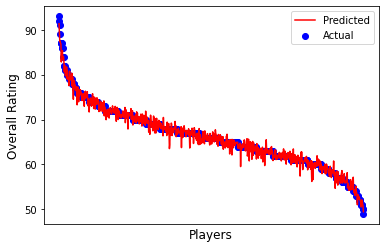

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(range(0, y_test.shape[0]), y_test,  color='b', label="Actual")
plt.plot(range(0, y_test.shape[0]), y_pred, color='r', label="Predicted")
plt.xticks(())
plt.xlabel("Players", size=12)
plt.ylabel("Overall Rating", size=12)
plt.legend(loc='upper right')
plt.show()

<h1>Build Model With Linear Regression To Predict Overall Rating Of Players For All Positions Except GK</h1>

In [ ]:
def PAC(df):
  return int(round((df[['Acceleration', 'Sprint_Speed']].mean())))
def SHO(df):
  return int(round((df[['Positioning', 'Finishing', 'Shot_Power', 'Long_Shots', 'Volleys', 'Penalties']].mean())))
def PAS(df):
  return int(round((df[['Vision', 'Crossing', 'FK_Accuracy', 'ShortPassing', 'Long_Passing', 'Curve']].mean())))
def DRI(df):
  return int(round((df[['Agility', 'Balance', 'Reactions', 'Ball_Control', 'Dribbling', 'Composure']].mean())))
def DEF(df):
  return int(round((df[['Interceptions', 'HeadingAccuracy', 'Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle']].mean())))
def PHY(df):
  return int(round((df[['Jumping', 'Stamina', 'Strength', 'Aggression']].mean())))
df_ovr = df4.copy()
df_ovr['PACE'] = df_ovr.apply(PAC, axis = 1)
df_ovr['SHOOTING'] = df_ovr.apply(SHO, axis = 1)
df_ovr['PASSING'] = df_ovr.apply(PAS, axis = 1)
df_ovr['DRIBBLING'] = df_ovr.apply(DRI, axis = 1)
df_ovr['DEFENDING'] = df_ovr.apply(DEF, axis = 1)
df_ovr['PHYSIC'] = df_ovr.apply(PHY, axis = 1)
df_ovr.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,club,club_url,nationality,nationality_url,nation_club,nation_club_url,PACE,SHOOTING,PASSING,DRIBBLING,DEFENDING,PHYSIC
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png,86,88,92,95,40,63
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png,78,91,78,86,47,82
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png,89,91,80,88,41,80
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png,52,20,31,52,18,58
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png,77,86,90,86,61,76


In [ ]:
from sklearn.model_selection import train_test_split

forward_position = ["ST", "LW", "RW", "LF", "RF", "RS","LS", "CF"]
midfielder_position = ["CM","RCM","LCM", "CDM","RDM","LDM", "CAM", "LAM", "RAM", "RM", "LM"]
defender_position = ["CB", "RCB", "LCB", "LWB", "RWB", "LB", "RB"]
df_by_pos = df_ovr.copy()
df_by_pos = df_by_pos[df_by_pos['primary_position'] != 'GK'] #ignore GK position because it has different attributes
df_by_pos.loc[df_by_pos["primary_position"].isin(defender_position), "primary_position"] = 'DF'
df_by_pos.loc[df_by_pos["primary_position"].isin(midfielder_position), "primary_position"] = 'MF'
df_by_pos.loc[df_by_pos["primary_position"].isin(forward_position), "primary_position"] = 'FW'

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

pd.options.mode.chained_assignment = None  # default='warn' #disable warning
features = ['PACE', 'SHOOTING', 'PASSING', 'DRIBBLING', 'DEFENDING', 'PHYSIC', 'Potential', 'age', 'Value', 'primary_position']
X = df_by_pos[features]
X.loc[:, 'primary_position'] = X.loc[:, 'primary_position'].apply(hash)
y = df_by_pos['Overall Rating']
X_train, X_Test, y_train, y_test = train_test_split(X, y, test_size=0.1)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_Test)
model = LinearRegression().fit(X_train,y_train)
print("Training score: " + str(model.score(X_train, y_train)))
print("Testing score: " + str(model.score(X_test, y_test)))

Training score: 0.898413873696652
Testing score: 0.8933427145437407


In [ ]:
list_order_to_name_player = []
for i in range(y_test.shape[0]):
  list_order_to_name_player.append(df_ovr.loc[y_test.index.values[i], 'short_name'])
len(list_order_to_name_player)

1683

In [ ]:
import numpy as np

data_testing = {'Order': y_test.index.values, 'Name': list_order_to_name_player, 'Overall Rating': y_test.values, 
                'Predicted Overall Rating': np.round(model.predict(X_test)).astype(int)}
df_testing = pd.DataFrame(data_testing)  
df_testing['Difference'] = ((df_testing['Predicted Overall Rating'] - df_testing['Overall Rating'])/df_testing['Overall Rating'])*100
df_testing.head()

,Order,Name,Overall Rating,Predicted Overall Rating,Difference
0,5553,V. Černý,69,66,-4.347826
1,5562,P. Klement,69,67,-2.898551
2,3434,Guto Milazar,72,69,-4.166667
3,12704,K. Kurokawa,63,62,-1.587302
4,10027,S. Ylätupa,65,64,-1.538462


In [ ]:
print("Total number of ovrall rating need to be predicted: " + str(df_testing.shape[0]))
print("Total number of overall rating predicted with 100% accuracy: " + str(df_testing[df_testing['Difference'] == 0.0].shape[0]))

Total number of ovrall rating need to be predicted: 1683
Total number of overall rating predicted with 100% accuracy: 326


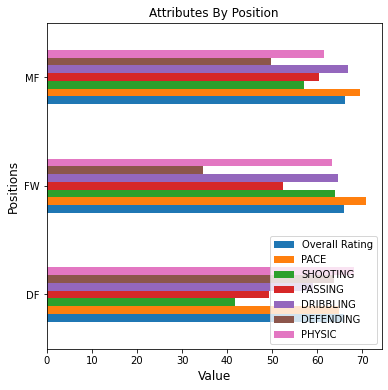

In [ ]:
import matplotlib.pyplot as plt

visualizeAttributeByPosition = df_by_pos.groupby([df_by_pos['primary_position']]).mean()
visualizeAttributeByPosition = visualizeAttributeByPosition[['Overall Rating', 'PACE', 'SHOOTING', 'PASSING', 'DRIBBLING', 'DEFENDING', 'PHYSIC']]
visualizeAttributeByPosition.plot(kind='barh', figsize=(6, 6))
plt.title("Attributes By Position", size=12)
plt.xlabel('Value', fontsize=12)
plt.ylabel('Positions', fontsize=12);

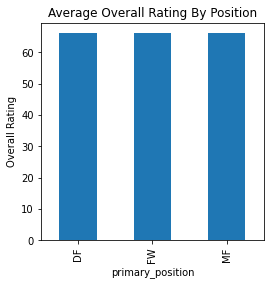

In [ ]:
visualizeOvrByPosition = df_by_pos.groupby('primary_position')['Overall Rating'].mean()
visualizeOvrByPosition.plot.bar(figsize=(4, 4))
plt.ylabel('Overall Rating')
plt.title('Average Overall Rating By Position')
plt.show()

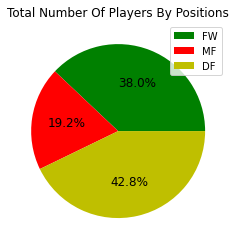

In [ ]:
visualizeTotalPlayerByPosition = df_by_pos.groupby('primary_position').count()['height']
visualizeTotalPlayerByPosition.plot(kind='pie', figsize=(4, 4), colors=['g','r','y'], labels=None, autopct='%1.1f%%', fontsize=12)
plt.legend(labels=df_by_pos['primary_position'].unique())
plt.title('Total Number Of Players By Positions', fontsize=12)
plt.ylabel('');

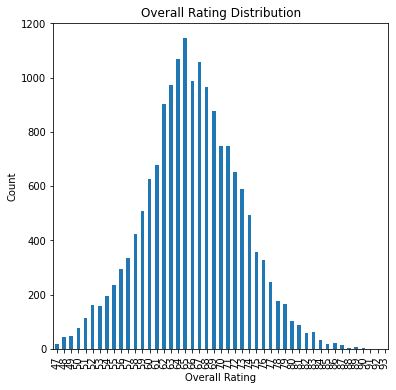

In [ ]:
visualizeDistributionOvr = df_by_pos.groupby('Overall Rating').count()['height']
visualizeDistributionOvr.plot.bar(figsize=(6, 6))
plt.ylabel('Count')
plt.title('Overall Rating Distribution')
plt.show()

<h1>Predict All Specific Positions Of Players</h1>

In [ ]:
df_new = df4.copy()
df_new = df_new[['primary_position', 'Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys',
           'Dribbling', 'Curve', 'FK_Accuracy', 'Long_Passing', 'Ball_Control',
           'Acceleration', 'Sprint_Speed', 'Agility', 'Reactions', 'Balance',
           'Shot_Power', 'Jumping', 'Stamina', 'Strength', 'Long_Shots',
           'Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
           'Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle',
           'GK_Diving', 'GK_Handling', 'GK_Kicking', 'GK_Positioning', 'GK_Reflexes']]
convert_position_to_number = {'RW': 0, 'ST': 1, 'GK': 2, 'CM': 3, 'LW': 4, 'CB': 5, 'CDM': 6, 'LM': 7, 'CF': 8, 'CAM': 9, 'LB': 10, 'RB': 11, 'RM': 12, 'RWB': 13,
                              'LWB': 14}
df_new = df_new.replace({'primary_position': convert_position_to_number})
df_new.head()

,primary_position,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes
0,0,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8
1,1,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10
2,1,84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11
3,2,13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90
4,3,94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13


In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(df_new.iloc[:,1:], df_new.iloc[:,0], random_state=42, test_size=0.3)
print('x train shape: {}'.format(x_train.shape))
print('x test shape: {}'.format(x_test.shape))
print('y train shape: {}'.format(y_train.shape))
print('y test shape: {}'.format(y_test.shape))

x train shape: (13245, 34)
x test shape: (5677, 34)
y train shape: (13245,)
y test shape: (5677,)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state=42).fit(x_train, y_train)
print('Training accuracy: {}'.format(model.score(x_train, y_train)))
print('Testing accuracy: {}'.format(model.score(x_test, y_test)))

Training accuracy: 1.0
Testing accuracy: 0.7082966355469438


In [ ]:
df_new_tmp = df4.copy()
list_order_to_name_player1 = []
for i in range(y_test.shape[0]):
  list_order_to_name_player1.append(df_new_tmp.loc[y_test.index.values[i], 'short_name'])
len(list_order_to_name_player1)

5677

In [ ]:
data_testing1 = {'Order': y_test.index.values, 'Name': list_order_to_name_player1, 'Position': y_test.values, 
                'Predicted Position': model.predict(x_test)}
df_testing1 = pd.DataFrame(data_testing1)  
df_testing1.head()

,Order,Name,Position,Predicted Position
0,8336,L. Schmitz,10,6
1,5282,Botía,5,5
2,4525,M. Dupé,2,2
3,17374,I. Dahlqvist,12,12
4,9243,A. Mabaso,11,10


In [ ]:
list_order_to_all_position_player = []
for i in range(y_test.shape[0]):
  list_order_to_all_position_player.append(df_new_tmp.loc[y_test.index.values[i], 'positions'])
len(list_order_to_all_position_player)

5677

In [ ]:
df_testing2 = df_testing1.copy()
convert_number_to_position = {0: 'RW', 1: 'ST', 2: 'GK', 3: 'CM', 4: 'LW', 5: 'CB', 6: 'CDM', 7: 'LM', 8: 'CF', 9: 'CAM', 10: 'LB', 11: 'RB', 12: 'RM', 13: 'RWB',
                              14: 'LWB'}
df_testing2 = df_testing2.replace({'Position': convert_number_to_position, 'Predicted Position': convert_number_to_position})
df_testing2.head()

,Order,Name,Position,Predicted Position
0,8336,L. Schmitz,LB,CDM
1,5282,Botía,CB,CB
2,4525,M. Dupé,GK,GK
3,17374,I. Dahlqvist,RM,RM
4,9243,A. Mabaso,RB,LB


In [ ]:
df_testing2['All Positions Player Can Play'] = list_order_to_all_position_player

In [ ]:
df_testing2[df_testing2['Position'] == df_testing2['Predicted Position']]

,Order,Name,Position,Predicted Position,All Positions Player Can Play
1,5282,Botía,CB,CB,['CB']
2,4525,M. Dupé,GK,GK,['GK']
3,17374,I. Dahlqvist,RM,RM,['RM']
5,1838,M. Eikrem,CAM,CAM,['CAM']
6,9050,Francés,CB,CB,['CB']
...,...,...,...,...,...
5672,10888,R. Takao,CB,CB,"['RB', 'CB']"
5673,17487,T. Tattermusch,ST,ST,['ST']
5674,14857,Hong Jin Gi,CB,CB,"['CB', 'LB']"
5675,7222,E. López,CAM,CAM,"['CAM', 'RM']"


In [ ]:
df_testing2[[a in b for a, b in zip(df_testing2['Predicted Position'], df_testing2['All Positions Player Can Play'])]]

,Order,Name,Position,Predicted Position,All Positions Player Can Play
1,5282,Botía,CB,CB,['CB']
2,4525,M. Dupé,GK,GK,['GK']
3,17374,I. Dahlqvist,RM,RM,['RM']
5,1838,M. Eikrem,CAM,CAM,['CAM']
6,9050,Francés,CB,CB,['CB']
...,...,...,...,...,...
5672,10888,R. Takao,CB,CB,"['RB', 'CB']"
5673,17487,T. Tattermusch,ST,ST,['ST']
5674,14857,Hong Jin Gi,CB,CB,"['CB', 'LB']"
5675,7222,E. López,CAM,CAM,"['CAM', 'RM']"


In [ ]:
#predict all specific positions of players by using pipeline and smote
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer

sm = SMOTE(random_state=42, sampling_strategy='minority')
x_train_balance, y_train_balance = sm.fit_sample(x_train, y_train)
my_pipeline = Pipeline([
      ('pt', PowerTransformer()),
      ('sc', StandardScaler()),
      ('model', RandomForestClassifier(random_state=42))
])
my_pipeline.fit(x_train_balance, y_train_balance)
print("Training accuracy: " + str(my_pipeline.score(x_train_balance, y_train_balance)))
print("Testing accuracy: " + str(my_pipeline.score(x_test, y_test)))

Training accuracy: 1.0
Testing accuracy: 0.7047736480535494


In [ ]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, plot_confusion_matrix, confusion_matrix

result_predicted = my_pipeline.predict(x_test)
print("F1 score: " + str(f1_score(y_test, result_predicted, average='weighted')))
print("Precision score: " + str(precision_score(y_test, result_predicted, average='weighted')))
print("Recall score: " + str(recall_score(y_test, result_predicted, average='weighted')))

F1 score: 0.673551391861882
Precision score: 0.6637501756894388
Recall score: 0.7047736480535494


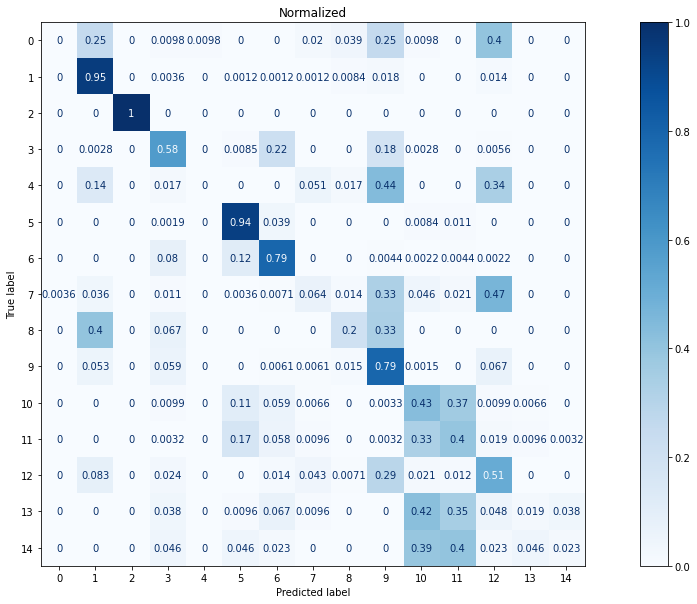

In [ ]:
import numpy as np

fig, ax = plt.subplots(figsize=(20, 10))
class_names = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
disp = plot_confusion_matrix(my_pipeline, x_test, y_test, display_labels=class_names, cmap=plt.cm.Blues, normalize='true', ax=ax)
disp.ax_.set_title("Normalized");

<h1>Visualize Data</h1>

In [ ]:
df_visualize = pd.read_csv('/content/player_info_preprocessed1.csv', encoding='utf-8-sig')

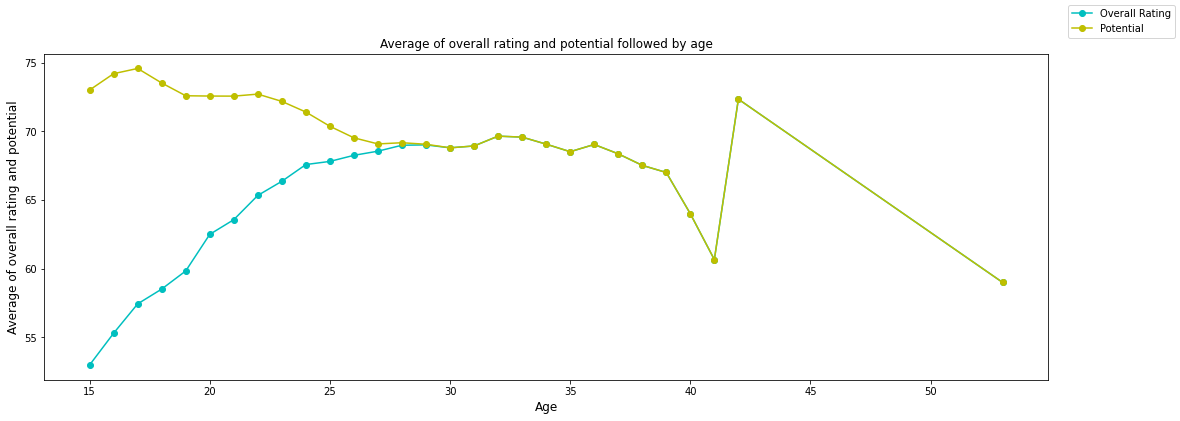

In [ ]:
import matplotlib.pyplot as plt

#correlation between age and overall rating/potential of player
correlation_age_overall_potential = df_visualize.groupby('age')[['Overall Rating', 'Potential']].mean().reset_index()
fig = plt.figure(figsize=(18, 6))
plt.plot(correlation_age_overall_potential['age'], correlation_age_overall_potential['Overall Rating'], color='c', marker='o', label='Overall Rating')
plt.plot(correlation_age_overall_potential['age'], correlation_age_overall_potential['Potential'], color='y', marker='o', label='Potential')
plt.xlabel("Age", size=12)
plt.ylabel("Average of overall rating and potential", size=12)
plt.title("Average of overall rating and potential followed by age", size=12)
fig.legend();

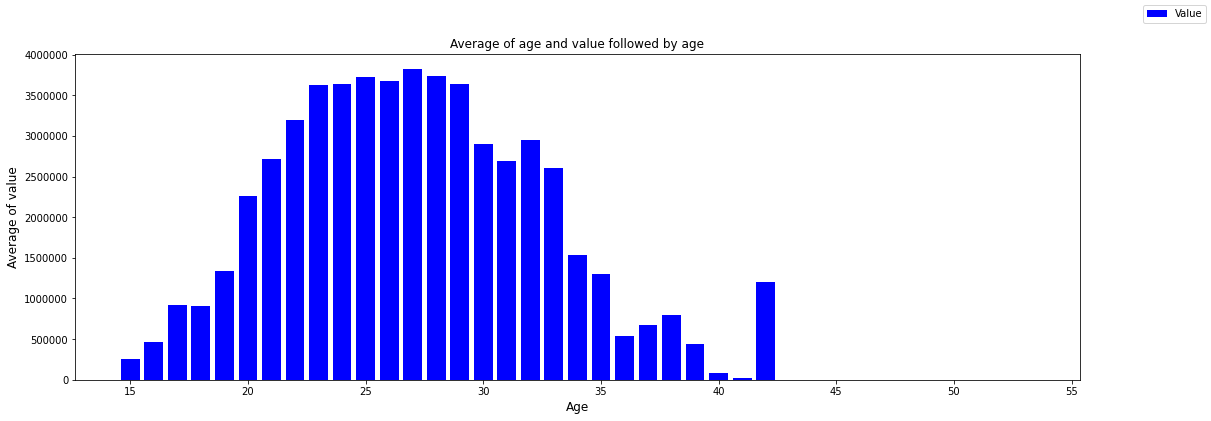

In [ ]:
#correlation between age and value of player
correlation_age_value = df_visualize.groupby('age')[['Value']].mean().reset_index()
fig = plt.figure(figsize=(18, 6))
plt.bar(correlation_age_value['age'], correlation_age_value['Value'], color='b', label='Value')
plt.xlabel("Age", size=12)
plt.ylabel("Average of value", size=12)
plt.title("Average of age and value followed by age", size=12)
plt.ticklabel_format(style='plain') #not show 1e6
fig.legend();

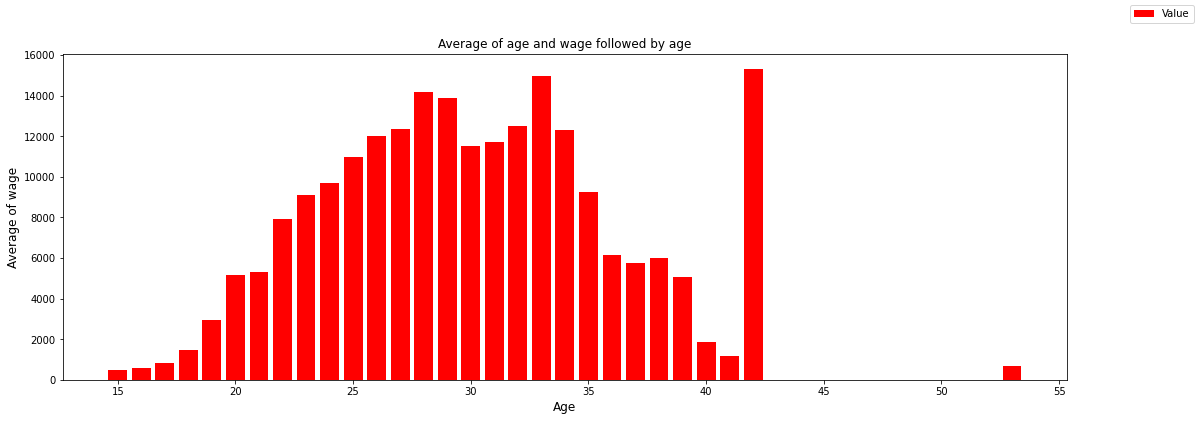

In [ ]:
#correlation between age and wage of player
correlation_age_wage = df_visualize.groupby('age')[['Wage']].mean().reset_index()
fig = plt.figure(figsize=(18, 6))
plt.bar(correlation_age_wage['age'], correlation_age_wage['Wage'], color='r', label='Value')
plt.xlabel("Age", size=12)
plt.ylabel("Average of wage", size=12)
plt.title("Average of age and wage followed by age", size=12)
plt.ticklabel_format(style='plain') #not show 1e6
fig.legend();

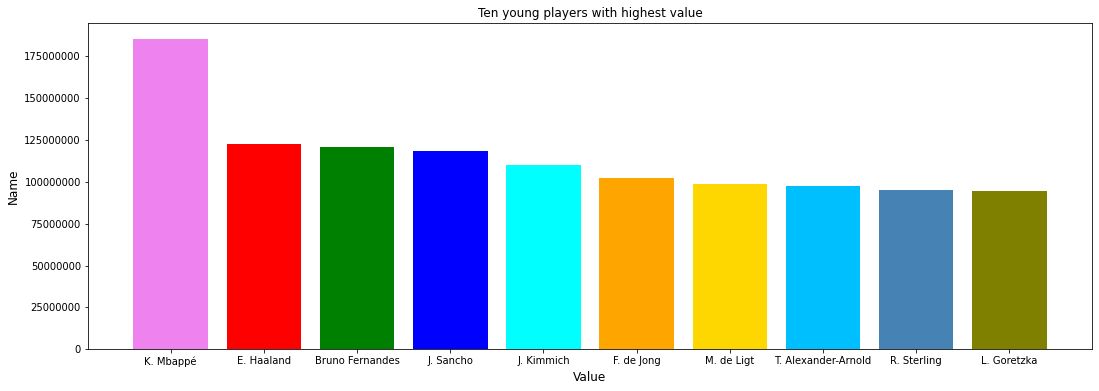

In [ ]:
#young player with highest value
young_player_high_value = df_visualize[df_visualize['age'] <= 25][['short_name', 'age', 'Value']].sort_values(['Value', 'age'], ascending=False)
top_ten_young_player = young_player_high_value.head(10)
plt.figure(figsize=(18, 6))
my_colors = ['violet', 'red', 'green', 'blue', 'cyan', 'orange', 'gold', 'deepskyblue', 'steelblue', 'olive']
plt.bar(top_ten_young_player['short_name'], top_ten_young_player['Value'], color=my_colors)
plt.xlabel("Value", size=12)
plt.ylabel("Name", size=12)
plt.title("Ten young players with highest value", size=12)
plt.ticklabel_format(axis='y', style='plain') #not show 1e6
plt.show()

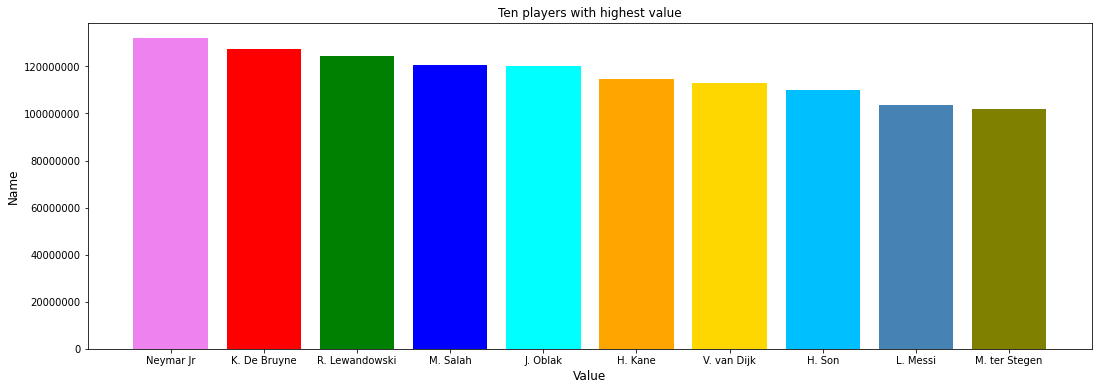

In [ ]:
#current player with highest value
current_player_high_value = df_visualize[df_visualize['age'] > 25][['short_name', 'age', 'Value']].sort_values(['Value', 'age'], ascending=False)
top_ten_player = current_player_high_value.head(10)
plt.figure(figsize=(18, 6))
my_colors = ['violet', 'red', 'green', 'blue', 'cyan', 'orange', 'gold', 'deepskyblue', 'steelblue', 'olive']
plt.bar(top_ten_player['short_name'], top_ten_player['Value'], color=my_colors)
plt.xlabel("Value", size=12)
plt.ylabel("Name", size=12)
plt.title("Ten players with highest value", size=12)
plt.ticklabel_format(axis='y', style='plain') #not show 1e6
plt.show()

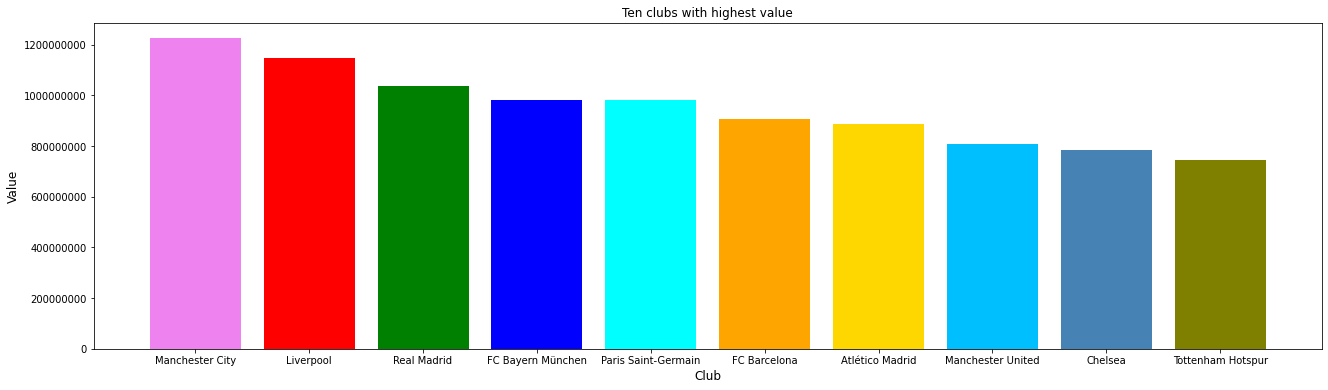

In [ ]:
#current club with highest value
top_clubs = df_visualize[['club', 'Value']].groupby('club').agg({'Value' : 'sum'}).reset_index()
top_club_high_value = top_clubs[['club', 'Value']].sort_values(['Value'], ascending=False)
top_ten_club = top_club_high_value.head(10)
plt.figure(figsize=(22, 6))
my_colors = ['violet', 'red', 'green', 'blue', 'cyan', 'orange', 'gold', 'deepskyblue', 'steelblue', 'olive']
plt.bar(top_ten_club['club'], top_ten_club['Value'], color=my_colors)
plt.xlabel("Club", size=12)
plt.ylabel("Value", size=12)
plt.title("Ten clubs with highest value", size=12)
plt.ticklabel_format(axis='y', style='plain') #not show 1e6
plt.show()

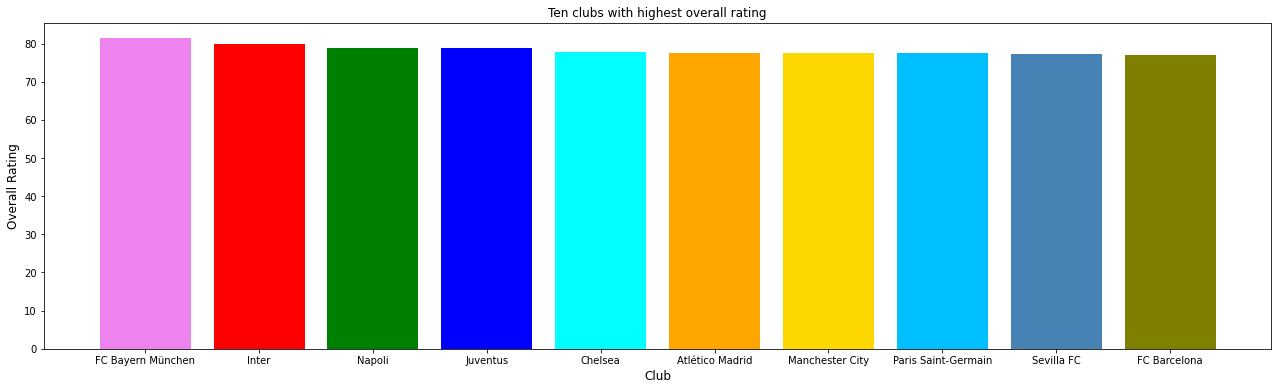

In [ ]:
#current club with highest overall
top_clubs_ovr = df_visualize[['club', 'Overall Rating']].groupby('club').agg({'Overall Rating' : 'mean'}).reset_index()
top_club_high_orv = top_clubs_ovr[['club', 'Overall Rating']].sort_values(['Overall Rating'], ascending=False)
top_ten_club_ovr = top_club_high_orv.head(10)
plt.figure(figsize=(22, 6))
my_colors = ['violet', 'red', 'green', 'blue', 'cyan', 'orange', 'gold', 'deepskyblue', 'steelblue', 'olive']
plt.bar(top_ten_club_ovr['club'], top_ten_club_ovr['Overall Rating'], color=my_colors)
plt.xlabel("Club", size=12)
plt.ylabel("Overall Rating", size=12)
plt.title("Ten clubs with highest overall rating", size=12)
plt.show()

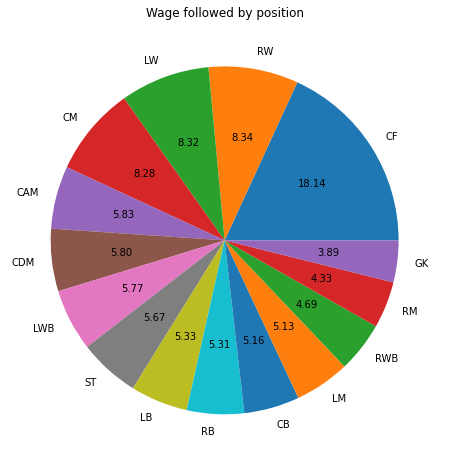

In [ ]:
#wage followed by position of player
wage_by_position = df_visualize[['primary_position', 'Wage']].groupby('primary_position').agg({'Wage':'mean'}) .reset_index().sort_values(['Wage'], ascending=False)
plt.figure(figsize=(8, 8))
plt.pie(wage_by_position['Wage'], labels=wage_by_position['primary_position'], autopct='%.2f')
plt.title('Wage followed by position', size=12);

In [ ]:
#highest overall rating of player follow by positions
best_player_follow_position = df_visualize[df_visualize['Overall Rating'] == df_visualize.groupby('primary_position')['Overall Rating'].transform(max)]
best_player_follow_position = best_player_follow_position[['short_name', 'primary_position', 'age', 'Overall Rating', 'Potential', 'Value', 'Wage', 'club', 'nationality']]
best_player_follow_position

,short_name,primary_position,age,Overall Rating,Potential,Value,Wage,club,nationality
0,L. Messi,RW,33,93,93,103500000.0,560000.0,FC Barcelona,Argentina
1,R. Lewandowski,ST,31,92,92,124500000.0,270000.0,FC Bayern München,Poland
2,Cristiano Ronaldo,ST,35,92,92,63000000.0,220000.0,Juventus,Portugal
3,J. Oblak,GK,27,91,93,120000000.0,125000.0,Atlético Madrid,Slovenia
4,K. De Bruyne,CM,29,91,91,127500000.0,370000.0,Manchester City,Belgium
5,Neymar Jr,LW,28,91,91,132000000.0,270000.0,Paris Saint-Germain,Brazil
8,V. van Dijk,CB,28,90,91,113000000.0,210000.0,Liverpool,Netherlands
12,J. Kimmich,CDM,25,89,90,110000000.0,150000.0,FC Bayern München,Germany
14,Casemiro,CDM,28,89,89,90500000.0,310000.0,Real Madrid,Brazil
15,H. Son,LM,27,89,89,110000000.0,210000.0,Tottenham Hotspur,Korea Republic


In [ ]:
#compute mean for attributes of each player followed by positions
df_visualize['Attacking'] = df_visualize[['Crossing', 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys']].apply(np.mean, axis=1)
df_visualize['Skill'] = df_visualize[['Dribbling', 'Curve', 'FK_Accuracy', 'Long_Passing', 'Ball_Control']].apply(np.mean, axis=1)
df_visualize['Movement'] = df_visualize[['Acceleration', 'Sprint_Speed', 'Agility', 'Reactions', 'Balance']].apply(np.mean, axis=1)
df_visualize['Power'] = df_visualize[['Shot_Power', 'Jumping', 'Stamina', 'Strength', 'Long_Shots']].apply(np.mean, axis=1)
df_visualize['Mentality'] = df_visualize[['Aggression', 'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure']].apply(np.mean, axis=1)
df_visualize['Defending'] = df_visualize[['Defensive_Awareness', 'Standing_Tackle', 'Sliding_Tackle']].apply(np.mean, axis=1)
df_visualize['Goalkeeping'] = df_visualize[[ 'GK_Diving', 'GK_Handling', 'GK_Kicking', 'GK_Positioning', 'GK_Reflexes']].apply(np.mean, axis=1)
df_visualize.head()

,id,name,short_name,photo_url,primary_position,positions,age,birth_date,height,weight,Overall Rating,Potential,Value,Wage,Preferred Foot,Weak Foot,Skill Moves,International Reputation,Work Rate,Body Type,Real Face,Release Clause,teams,player_traits,player_specialities,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FK_Accuracy,Long_Passing,Ball_Control,Acceleration,Sprint_Speed,Agility,Reactions,Balance,Shot_Power,Jumping,Stamina,Strength,Long_Shots,Aggression,Interceptions,Positioning,Vision,Penalties,Composure,Defensive_Awareness,Standing_Tackle,Sliding_Tackle,GK_Diving,GK_Handling,GK_Kicking,GK_Positioning,GK_Reflexes,club,club_url,nationality,nationality_url,nation_club,nation_club_url,Attacking,Skill,Movement,Power,Mentality,Defending,Goalkeeping
0,158023,Lionel Andrés Messi Cuccittini,L. Messi,https://cdn.sofifa.com/players/158/023/21_120.png,RW,"['RW', 'ST', 'CF']",33,1987/Jun/24,170,72,93,93,103500000.0,560000.0,Left,4,4,5,Medium/ Low,Unique,Yes,212200000.0,"{'FC Barcelona': 84, 'Argentina': 83}","['Finesse Shot', 'Long Shot Taker (AI)', 'Spee...","['#Dribbler', '#Distance Shooter', '#FK Specia...",85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,32,35,24,6,11,15,14,8,FC Barcelona,https://cdn.sofifa.com/teams/241/60.png,Argentina,https://cdn.sofifa.com/flags/ar.png,Argentina,https://cdn.sofifa.com/teams/1369/60.png,85.8,94.0,90.2,77.8,73.833333,30.333333,10.8
1,188545,Robert Lewandowski,R. Lewandowski,https://cdn.sofifa.com/players/188/545/21_120.png,ST,['ST'],31,1988/Aug/21,185,81,92,92,124500000.0,270000.0,Right,4,4,4,High/ Medium,Unique,Yes,205400000.0,"{'FC Bayern München': 84, 'Poland': 77}","['Solid Player', 'Finesse Shot', 'Outside Foot...","['#Aerial Threat', '#Distance Shooter', '#Clin...",71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,84,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,FC Bayern München,https://cdn.sofifa.com/teams/21/60.png,Poland,https://cdn.sofifa.com/flags/pl.png,Poland,https://cdn.sofifa.com/teams/1353/60.png,86.0,81.4,81.6,84.6,80.666667,32.000000,10.2
2,20801,Cristiano Ronaldo dos Santos Aveiro,Cristiano Ronaldo,https://cdn.sofifa.com/players/020/801/21_120.png,ST,"['ST', 'LW']",35,1985/Feb/5,187,83,92,92,63000000.0,220000.0,Right,4,5,5,High/ Low,Unique,Yes,104000000.0,"{'Juventus': 83, 'Portugal': 83}","['Power Free-Kick', 'Flair', 'Long Shot Taker ...","['#Aerial Threat', '#Dribbler', '#Distance Sho...",84,95,90,82,86,88,81,76,77,92,87,91,87,95,71,94,95,84,78,93,63,29,95,82,84,95,28,32,24,7,11,15,14,11,Juventus,https://cdn.sofifa.com/teams/45/60.png,Portugal,https://cdn.sofifa.com/flags/pt.png,Portugal,https://cdn.sofifa.com/teams/1354/60.png,87.4,82.8,86.2,88.8,74.666667,28.000000,11.6
3,200389,Jan Oblak,J. Oblak,https://cdn.sofifa.com/players/200/389/21_120.png,GK,['GK'],27,1993/Jan/7,188,87,91,93,120000000.0,125000.0,Right,3,1,3,Medium/ Medium,Unique,Yes,255000000.0,"{'Atlético Madrid': 83, 'Slovenia': 73}","['GK Long Throw', 'Comes For Crosses']",[],13,11,15,43,13,12,13,14,40,30,43,60,67,88,49,59,78,41,78,12,34,19,11,65,11,68,27,12,18,87,92,78,90,90,Atlético Madrid,https://cdn.sofifa.com/teams/240/60.png,Slovenia,https://cdn.sofifa.com/flags/si.png,Slovenia,https://cdn.sofifa.com/teams/1361/60.png,19.0,21.8,61.4,53.6,34.666667,19.000000,87.4
4,192985,Kevin De Bruyne,K. De Bruyne,https://cdn.sofifa.com/players/192/985/21_120.png,CM,"['CM', 'CAM', 'CF']",29,1991/Jun/28,181,70,91,91,127500000.0,370000.0,Right,5,4,4,High/ High,Unique,Yes,235900000.0,"{'Manchester City': 85, 'Belgium': 83}","['Injury Prone', 'Leadership', 'Early Crosser'...","['#Dribbler', '#Playmaker\xa0', '#Engine', '#D...",94,82,55,94,82,88,85,83,93,92,77,77,79,91,78,91,63,89,74,91,76,66,88,94,83,91,68,65,53,15,13,5,10,13,Manchester City,https://cdn.sofifa.com/teams/10/60.png,Belgium,https://cdn.sofifa.com/flags/be.png,Belgium,https://cdn.sofifa.com/teams/1325/60.png,81.4,88.2,80.4,81.6,83.000000,62.000000,11.2


In [ ]:
vital_attribute_by_positions = df_visualize.groupby('primary_position')[['Attacking', 'Skill', 'Movement', 'Power', 'Mentality', 'Defending', 'Goalkeeping']].agg('mean')
def color_highlight(val):
  if val == vital_attribute_by_positions.max(axis=1)[0] or val == vital_attribute_by_positions.max(axis=1)[1] or val == vital_attribute_by_positions.max(axis=1)[2] or \
  val == vital_attribute_by_positions.max(axis=1)[3] or val == vital_attribute_by_positions.max(axis=1)[4] or val == vital_attribute_by_positions.max(axis=1)[5] or \
  val == vital_attribute_by_positions.max(axis=1)[6] or val == vital_attribute_by_positions.max(axis=1)[7] or val == vital_attribute_by_positions.max(axis=1)[8] or \
  val == vital_attribute_by_positions.max(axis=1)[9] or val == vital_attribute_by_positions.max(axis=1)[10] or val == vital_attribute_by_positions.max(axis=1)[11] or \
  val == vital_attribute_by_positions.max(axis=1)[12] or val == vital_attribute_by_positions.max(axis=1)[13] or val == vital_attribute_by_positions.max(axis=1)[14]: color = 'red'
  else: color = 'black'
  return 'color: %s' % color
vital_attribute_by_positions.style.applymap(color_highlight)

,Attacking,Skill,Movement,Power,Mentality,Defending,Goalkeeping
primary_position,,,,,,,
CAM,57.198415,63.238820,69.891285,60.096303,56.864510,43.578638,10.275704
CB,46.252372,45.643806,57.860287,59.264787,52.054622,65.798139,10.459854
CDM,54.254421,58.751337,63.688965,64.925840,60.912497,64.911355,10.510761
CF,66.436364,67.087879,72.472727,68.336364,61.851010,33.777778,10.163636
CM,58.494280,64.055904,66.179151,65.487454,62.919434,61.094096,10.492804
GK,15.494280,17.427836,42.680553,41.019828,25.092628,13.795996,63.879123
LB,52.395862,55.937537,68.785616,60.169458,56.206732,63.523810,10.548966
LM,57.606912,61.153400,72.154961,61.069342,55.006132,41.238201,10.338907
LW,60.314583,62.586458,74.852083,62.050000,55.866319,34.043403,10.439583


In [ ]:
import plotly.express as px
import plotly.graph_objects as go

#average ovr of player followed by nations
nationality_ovr_df = df_visualize.groupby('nationality')['Overall Rating'].agg('mean').to_frame().reset_index()
fig = go.Figure(data=go.Choropleth(
    locations = nationality_ovr_df['nationality'],
    z = nationality_ovr_df['Overall Rating'],
    text = nationality_ovr_df['nationality'],
    colorscale = 'Reds',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Overall Rating',
    locationmode='country names'
))
fig.update_layout(title_text='Overall rating followed by nations')
fig.show()

In [ ]:
#average potential of player followed by nations
nationality_potential_df = df_visualize.groupby('nationality')['Potential'].agg('mean').to_frame().reset_index()
fig = go.Figure(data=go.Choropleth(
    locations = nationality_potential_df['nationality'],
    z = nationality_potential_df['Potential'],
    text = nationality_potential_df['nationality'],
    colorscale = 'Blues',
    autocolorscale=False,
    reversescale=True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
    colorbar_title = 'Potential',
    locationmode='country names'
))
fig.update_layout(title_text='Potential followed by nations')
fig.show()

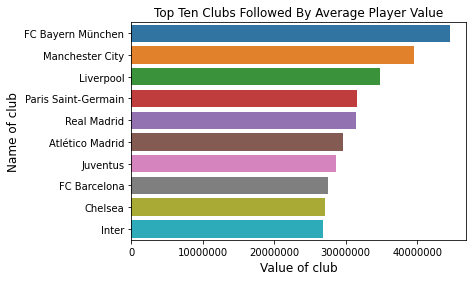

In [ ]:
import seaborn as sns
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning) #remove warning sns

#club with most valuable players
club_high_value = pd.DataFrame(df_visualize.groupby("club")["Value"].mean()).sort_values(by="Value", ascending=False).reset_index()
top_10_club_value = club_high_value.head(10)
sns.barplot(top_10_club_value['Value'], top_10_club_value['club'])
plt.xlabel("Value of club", size=12)
plt.ylabel("Name of club", size=12)
plt.title("Top Ten Clubs Followed By Average Player Value", size=12)
plt.ticklabel_format(axis='x', style='plain') #not show 1e6
plt.show()

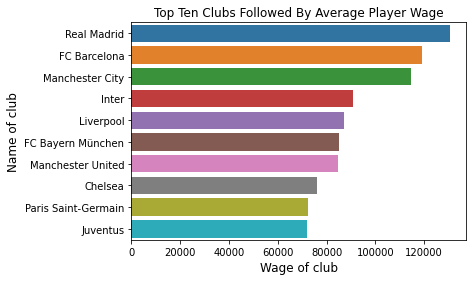

In [ ]:
#club pays highest average wage for player
club_high_wage = pd.DataFrame(df_visualize.groupby("club")["Wage"].mean()).sort_values(by="Wage", ascending=False).reset_index()
top_10_club_wage = club_high_wage.head(10)
sns.barplot(top_10_club_wage['Wage'], top_10_club_wage['club'])
plt.xlabel("Wage of club", size=12)
plt.ylabel("Name of club", size=12)
plt.title("Top Ten Clubs Followed By Average Player Wage", size=12)
plt.ticklabel_format(axis='x', style='plain') #not show 1e6
plt.show()